In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import locale
from utils.graph import Graph
locale.setlocale(locale.LC_TIME, 'pt_BR.utf8')
util_graph = Graph()

# Carregar Dados

In [2]:
df_estoque_ruptura = pd.read_csv('../data/processed/dados_estoque_ruptura.csv')
df_estoque_ruptura['dt_estoque'] = pd.to_datetime(df_estoque_ruptura['dt_estoque'])
df_estoque_ruptura['ano_mes'] = df_estoque_ruptura['dt_estoque'].dt.strftime('%Y-%m')
df_estoque_ruptura['is_ruptura'] = df_estoque_ruptura['is_ruptura'].apply(int)
df_estoque_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes
0,1,1428,2024-01-01,108.0,0,2024-01
1,1,1428,2024-01-02,108.0,0,2024-01
2,1,1428,2024-01-03,108.0,0,2024-01
3,1,1428,2024-01-04,108.0,0,2024-01
4,1,1428,2024-01-05,108.0,0,2024-01


In [3]:
df_similares = pd.read_csv('../data/raw/tb_similares.csv')
df_similares.rename(columns={"cod_material": "cod_produto"}, inplace=True)
df_similares.head()

,cod_produto,cod_material_recom,ranking
0,48635,25472,1
1,50651,74932,1
2,48062,77684,1
3,49893,48730,1
4,49943,84203,1


In [4]:
df_vendas = pd.read_csv('../data/processed/df_vendas_consolidado.csv')
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])
df_vendas.head()

,dt_venda,key_loja,cod_produto,qtd_vendas,vlr_venda_tabelado_mean,vlr_desconto_mean,categoria_produto,sub_categoria_produto,linha_produto
0,2024-01-02,1,48062,1,284.70,0.0,217.0,422944,306420
1,2024-01-02,1,48635,1,419.70,0.0,955075.0,483679,284036
2,2024-01-02,1,82060,1,1017.00,191.1,157293.0,483679,120030
3,2024-01-02,2,1650,1,167.70,36.0,217.0,422944,731659
4,2024-01-02,2,48060,2,584.55,0.0,217.0,422944,306420


In [5]:
df_desc_prod = df_vendas[['cod_produto', 'key_loja' ,'categoria_produto', 'sub_categoria_produto', 'linha_produto']].drop_duplicates()
df_desc_prod['cod_produto'].value_counts()

cod_produto
48062    8
48635    8
82060    8
1650     8
48060    8
        ..
91669    5
83772    5
47910    1
3724     1
74932    1
Name: count, Length: 96, dtype: int64

In [6]:
df_tmp = df_estoque_ruptura.merge(df_similares, on='cod_produto', how='left')

df_estoque_ruptura_similar = df_tmp.merge(
    df_estoque_ruptura,
    left_on=['cod_material_recom', 'key_loja', 'dt_estoque'],
    right_on=['cod_produto', 'key_loja', 'dt_estoque'],
    how='left',
    suffixes=('', '_similar')
)

df_estoque_ruptura_similar['similar_disponivel'] = df_estoque_ruptura_similar['qt_estoque_similar'] > 0
df_estoque_ruptura_similar['similar_disponivel'] = df_estoque_ruptura_similar['similar_disponivel'].apply(int)

df_estoque_ruptura_similar.drop(columns=['cod_material_recom', 'is_ruptura_similar', 'ano_mes_similar'], inplace=True)

df_estoque_ruptura_similar.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,cod_produto_similar,qt_estoque_similar,similar_disponivel
0,1,1428,2024-01-01,108.0,0,2024-01,1.0,1650.0,102.0,1
1,1,1428,2024-01-01,108.0,0,2024-01,2.0,1640.0,83.0,1
2,1,1428,2024-01-01,108.0,0,2024-01,3.0,48282.0,335.0,1
3,1,1428,2024-01-02,108.0,0,2024-01,1.0,1650.0,102.0,1
4,1,1428,2024-01-02,108.0,0,2024-01,2.0,1640.0,83.0,1


# Como os Produtos Similares estão se Comportando quando ocorre ruptura?

## Loja 5

In [7]:
lj = 5

In [8]:
df_loja = df_estoque_ruptura_similar[(df_estoque_ruptura_similar['key_loja']==lj)&(df_estoque_ruptura_similar['is_ruptura']==1)]

### Qual Ranking tem mais Recomendação ?

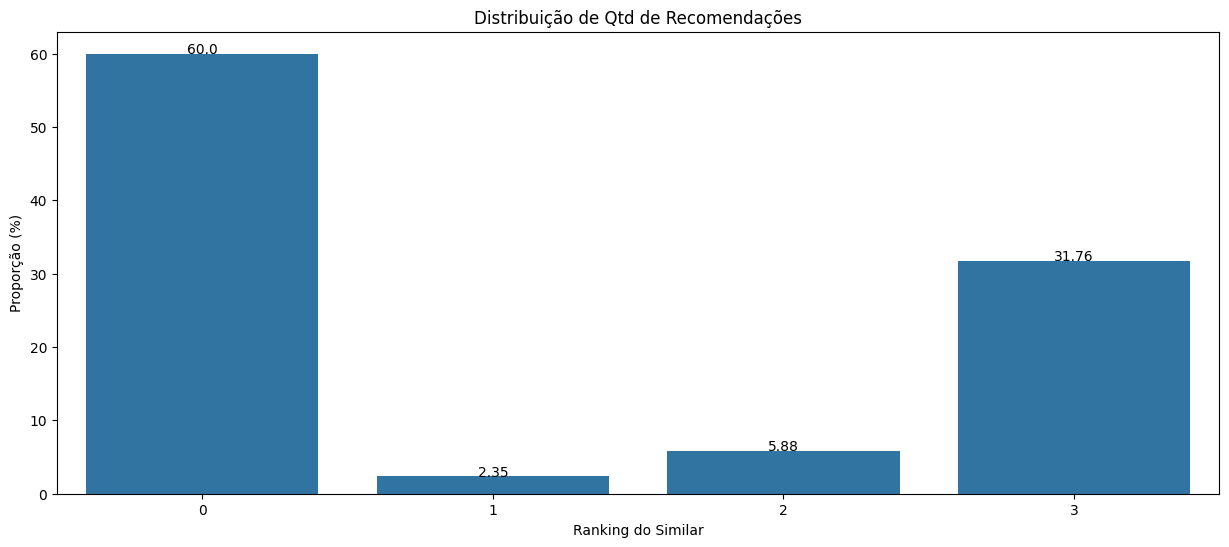

In [9]:
df_ranking_por_produto = df_loja.groupby('cod_produto')['ranking'].nunique().reset_index(name='qtd_similares')
df_dist_similares = df_ranking_por_produto['qtd_similares'].value_counts(normalize=True).sort_index().reset_index()
df_dist_similares['proportion'] = np.round(df_dist_similares['proportion']*100,2)

util_graph.create_graph_bar(df_dist_similares, 'qtd_similares', 'proportion', 'Ranking do Similar', 'Proporção (%)', 'Distribuição de Qtd de Recomendações')

- Mais da metade dos produtos da loja 8 não possue produtos similares

#### Por Categorias + Sub_Categoria + Linha Produto

In [10]:
df_loja_desc_prod = df_loja.merge(df_desc_prod, on=['cod_produto','key_loja'], how='left')
df_loja_desc_prod[df_loja_desc_prod['categoria_produto'].isnull()]['cod_produto'].unique()

array([24499, 28694, 47910, 49186, 57042, 58565, 74932, 82026, 82719,
       83772, 84064, 84068, 85124])

- Alguns produtos ficaram sem categoria por não ter referencia na base de venda, com isso irei atribuir **"sem categoria"**, **sem_sub** para coluna sub_categoria_produto e **sem_linha** para linha_produto. No cenário real daria para buscar essa informação na base de produtos

In [11]:
df_loja_desc_prod.fillna(value={'categoria_produto':'sem_categoria', 'sub_categoria_produto':'sem_sub', 'linha_produto':'sem_linha'}, inplace=True)
df_loja_desc_prod['categoria_produto'] = df_loja_desc_prod['categoria_produto'].astype(str)
df_loja_desc_prod['sub_categoria_produto'] = df_loja_desc_prod['sub_categoria_produto'].astype(str)
df_loja_desc_prod['linha_produto'] = df_loja_desc_prod['linha_produto'].astype(str)

In [12]:
df_loja_desc_prod['descricao_completa'] = df_loja_desc_prod['categoria_produto'] + ' + ' + df_loja_desc_prod['sub_categoria_produto'] + ' + ' + df_loja_desc_prod['linha_produto']
df_loja_desc_prod.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,cod_produto_similar,qt_estoque_similar,similar_disponivel,categoria_produto,sub_categoria_produto,linha_produto,descricao_completa
0,5,1428,2024-11-13,0.0,1,2024-11,1.0,1650.0,10.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0
1,5,1428,2024-11-13,0.0,1,2024-11,2.0,1640.0,19.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0
2,5,1428,2024-11-13,0.0,1,2024-11,3.0,48282.0,1150.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0
3,5,1428,2024-11-14,0.0,1,2024-11,1.0,1650.0,7.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0
4,5,1428,2024-11-14,0.0,1,2024-11,2.0,1640.0,18.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0


In [13]:
df_ranking_por_produto_descr = df_loja_desc_prod.groupby(['cod_produto', 'descricao_completa'])['ranking'].nunique().reset_index(name='qtd_similares')
df_agg = df_ranking_por_produto_descr.groupby(['descricao_completa', 'qtd_similares']).size().reset_index(name='qtd_produtos')

df_agg['percentual'] = (
    df_agg['qtd_produtos'] / 
    df_agg.groupby('descricao_completa')['qtd_produtos'].transform('sum') * 100
)

df_agg['percentual'] = df_agg['percentual'].round(2)

df_agg.head()

,descricao_completa,qtd_similares,qtd_produtos,percentual
0,157293.0 + 311781.0 + 109471.0,0,2,100.0
1,157293.0 + 311781.0 + 736254.0,3,1,100.0
2,157293.0 + 483679.0 + 120030.0,0,2,100.0
3,157293.0 + 483679.0 + 147447.0,0,1,100.0
4,157293.0 + 483679.0 + 212257.0,3,1,100.0


In [ ]:
# df_plot = df_agg.pivot(index='descricao_completa', columns='qtd_similares', values='qtd_produtos')
# ordened = True
# if ordened:
#     df_plot = df_plot.sort_values(list(df_plot.columns),ascending=False)

# ax = df_plot.plot(kind='bar', figsize=(15, 7), width=0.9)

# # Adicionar título e eixos
# # ax.set_xlabel(x_label)
# # ax.set_ylabel(y_label)
# # ax.set_title(title)
# # ax.legend(title=legend)
# ax.set_xticklabels(df_plot.index, rotation=45, ha='right')

# # Adicionar valores nas barras
# for container in ax.containers:
#     ax.bar_label(container, padding=3, fontsize=9)

# plt.tight_layout()
# plt.show()

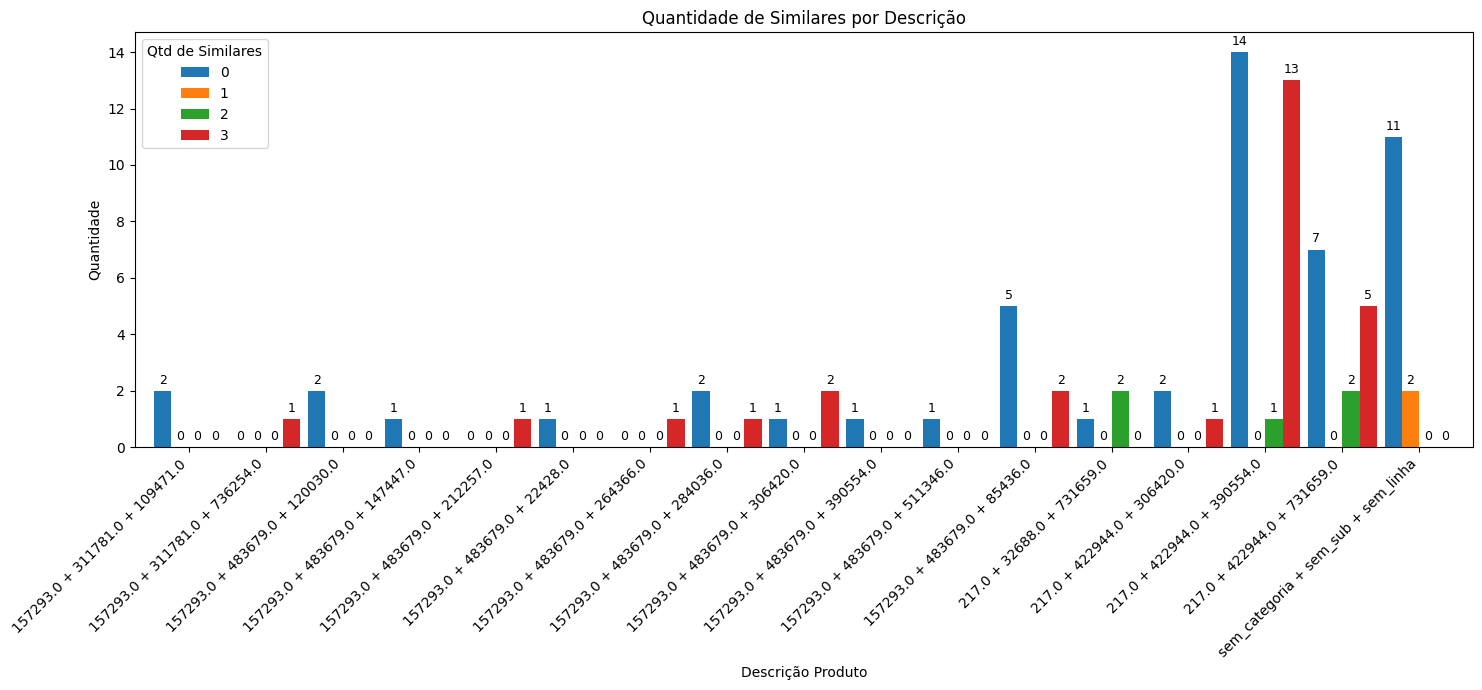

In [14]:
util_graph.create_graph_multi_bar(df_agg, 'descricao_completa', 'qtd_similares', 'qtd_produtos', 'Descrição Produto', 'Quantidade', 
                                  'Quantidade de Similares por Descrição', 'Qtd de Similares')

### Qual o Grau de Disponibilidade por Ranking ?

In [15]:
df_loja_similar = df_loja_desc_prod[~df_loja_desc_prod['ranking'].isnull()]
df_loja_similar.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,cod_produto_similar,qt_estoque_similar,similar_disponivel,categoria_produto,sub_categoria_produto,linha_produto,descricao_completa
0,5,1428,2024-11-13,0.0,1,2024-11,1.0,1650.0,10.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0
1,5,1428,2024-11-13,0.0,1,2024-11,2.0,1640.0,19.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0
2,5,1428,2024-11-13,0.0,1,2024-11,3.0,48282.0,1150.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0
3,5,1428,2024-11-14,0.0,1,2024-11,1.0,1650.0,7.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0
4,5,1428,2024-11-14,0.0,1,2024-11,2.0,1640.0,18.0,1,217.0,422944.0,731659.0,217.0 + 422944.0 + 731659.0


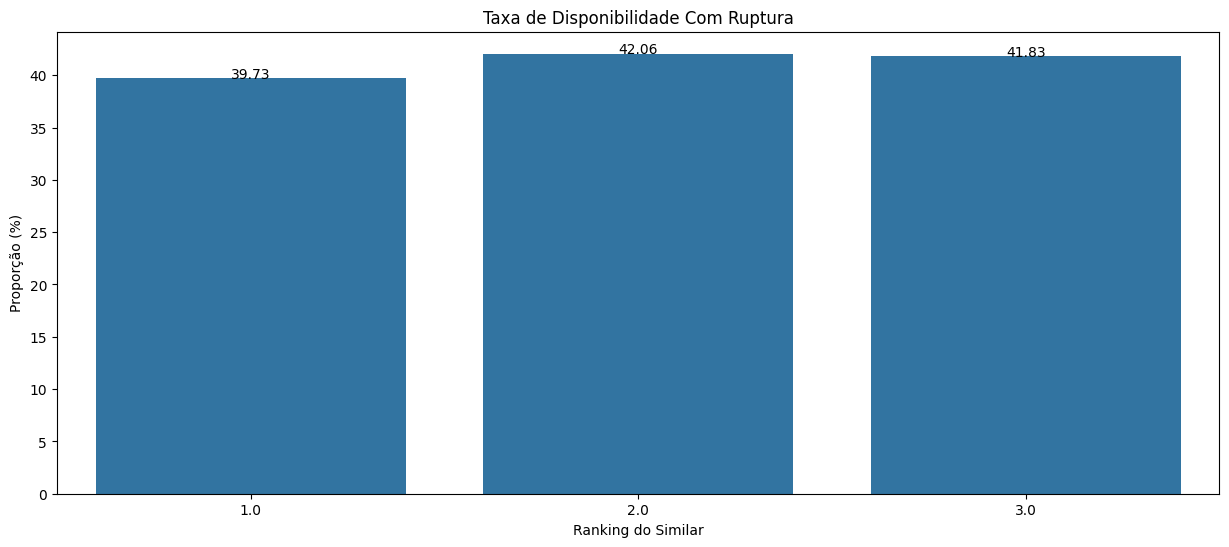

In [16]:
disponibilidade_por_rank = (
    df_loja_similar.groupby(['ranking'], as_index=False)['similar_disponivel']
    .agg(qtd_similares_disponiveis='sum', total='count')
    .assign(taxa_disponibilidade=lambda x: np.round((x['qtd_similares_disponiveis'] / x['total'])*100,2))
    )
disponibilidade_por_rank

util_graph.create_graph_bar(disponibilidade_por_rank, 'ranking', 'taxa_disponibilidade', 'Ranking do Similar', 
                 'Proporção (%)', 'Taxa de Disponibilidade Com Ruptura')

#### Por Categorias + Sub_Categoria + Linha Produto

In [17]:
disponibilidade_por_descricao = (
    df_loja_similar.groupby(['descricao_completa', 'ranking'], as_index=False)['similar_disponivel']
    .agg(qtd_similares_disponiveis='sum', total='count')
    .assign(taxa_disponibilidade=lambda x: np.round((x['qtd_similares_disponiveis'] / x['total'])*100,2))
    )
disponibilidade_por_descricao.head()

,descricao_completa,ranking,qtd_similares_disponiveis,total,taxa_disponibilidade
0,157293.0 + 311781.0 + 736254.0,1.0,32,32,100.00
1,157293.0 + 311781.0 + 736254.0,2.0,0,32,0.00
2,157293.0 + 311781.0 + 736254.0,3.0,32,32,100.00
3,157293.0 + 483679.0 + 212257.0,1.0,45,45,100.00
4,157293.0 + 483679.0 + 212257.0,2.0,12,45,26.67


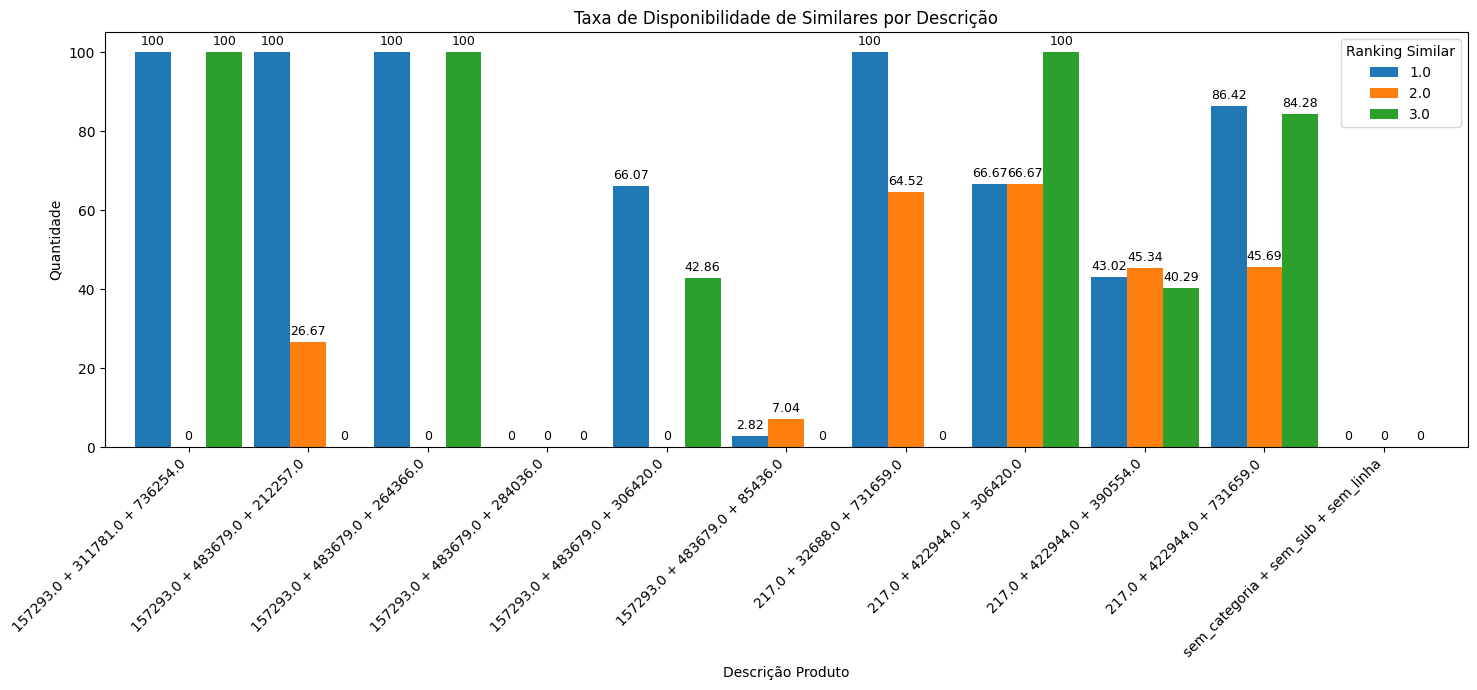

In [18]:
util_graph.create_graph_multi_bar(disponibilidade_por_descricao, 'descricao_completa', 'ranking', 'taxa_disponibilidade', 'Descrição Produto', 'Quantidade', 
                                  'Taxa de Disponibilidade de Similares por Descrição', 'Ranking Similar')

### Qual o Ranking mais Vendido?

Vamos filtrar os casos que o produto estava em ruptura e possuia similares disponiveis. Quero observar se os similares estão conseguindo ter uma boa taxa de substituição

In [19]:
df_loja_similar_disponivel = df_loja_similar[df_loja_similar['similar_disponivel']==1]

vendas_similares = df_loja_similar_disponivel.merge(
    df_vendas[['dt_venda', 'key_loja', 'cod_produto', 'qtd_vendas', 'vlr_venda_tabelado_mean', 'vlr_desconto_mean']], 
    left_on=['cod_produto_similar', 'key_loja', 'dt_estoque'], 
    right_on=['cod_produto', 'key_loja', 'dt_venda'], how='left',
    suffixes=('', '_similar_venda'))

vendas_similares.drop(columns=['categoria_produto', 'sub_categoria_produto', 'linha_produto', 'cod_produto_similar_venda'], inplace=True)
vendas_similares['venda_similar'] = vendas_similares['qtd_vendas']>0
vendas_similares['venda_similar'] = vendas_similares['venda_similar'].apply(int)
vendas_similares.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,cod_produto_similar,qt_estoque_similar,similar_disponivel,descricao_completa,dt_venda,qtd_vendas,vlr_venda_tabelado_mean,vlr_desconto_mean,venda_similar
0,5,1428,2024-11-13,0.0,1,2024-11,1.0,1650.0,10.0,1,217.0 + 422944.0 + 731659.0,2024-11-13,2.0,188.7,39.0,1
1,5,1428,2024-11-13,0.0,1,2024-11,2.0,1640.0,19.0,1,217.0 + 422944.0 + 731659.0,2024-11-13,1.0,179.7,36.0,1
2,5,1428,2024-11-13,0.0,1,2024-11,3.0,48282.0,1150.0,1,217.0 + 422944.0 + 731659.0,2024-11-13,6.0,248.7,0.0,1
3,5,1428,2024-11-14,0.0,1,2024-11,1.0,1650.0,7.0,1,217.0 + 422944.0 + 731659.0,NaT,NaN,NaN,NaN,0
4,5,1428,2024-11-14,0.0,1,2024-11,2.0,1640.0,18.0,1,217.0 + 422944.0 + 731659.0,NaT,NaN,NaN,NaN,0


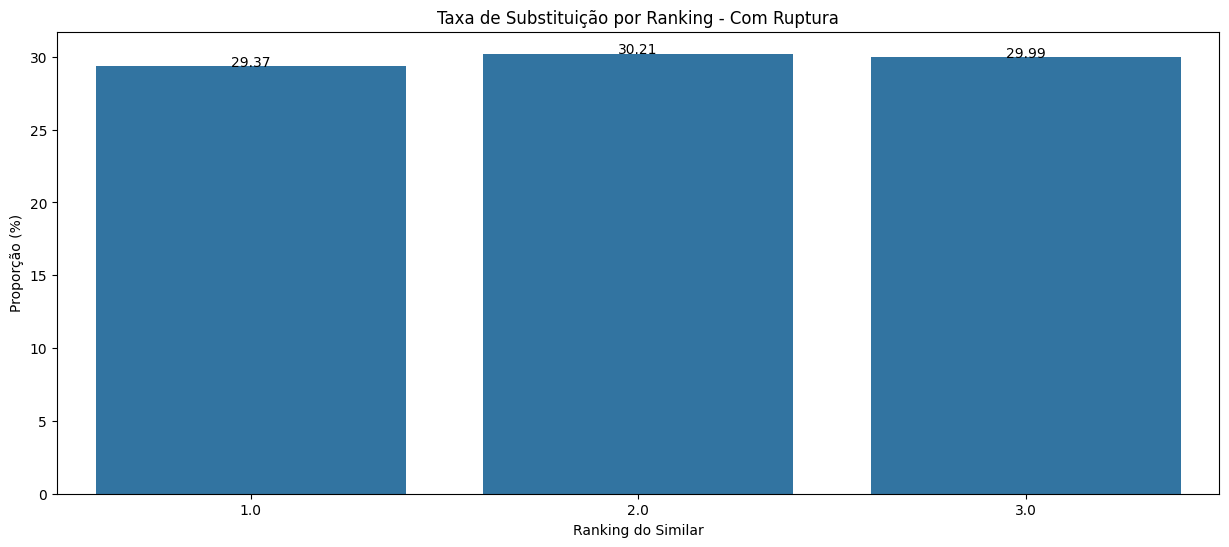

In [20]:
resultado_substituicao_similar = vendas_similares.groupby(['dt_estoque', 'key_loja', 'cod_produto', 'ranking'],as_index=False)['venda_similar'].max()
taxa_substituicao = (
    resultado_substituicao_similar.groupby(['ranking'],as_index=False)['venda_similar']
    .agg(qtd_vendas_similares='sum', total='count')
    .assign(taxa_substituicao=lambda x: np.round((x['qtd_vendas_similares'] / x['total'])*100, 2))
    )

util_graph.create_graph_bar(taxa_substituicao, 'ranking', 'taxa_substituicao', 'Ranking do Similar', 'Proporção (%)', 'Taxa de Substituição por Ranking - Com Ruptura')

#### Por Categorias + Sub_Categoria + Linha Produto

In [21]:
resultado_substituicao_similar = vendas_similares.groupby(['dt_estoque', 'key_loja', 'cod_produto', 'descricao_completa','ranking'],as_index=False)['venda_similar'].max()
resultado_substituicao_similar

taxa_substituicao = (
    resultado_substituicao_similar.groupby(['descricao_completa', 'ranking'],as_index=False)['venda_similar']
    .agg(qtd_vendas_similares='sum', total='count')
    .assign(taxa_substituicao=lambda x: np.round((x['qtd_vendas_similares'] / x['total'])*100, 2))
    )

taxa_substituicao.head()

,descricao_completa,ranking,qtd_vendas_similares,total,taxa_substituicao
0,157293.0 + 311781.0 + 736254.0,1.0,2,32,6.25
1,157293.0 + 311781.0 + 736254.0,3.0,23,32,71.88
2,157293.0 + 483679.0 + 212257.0,1.0,26,45,57.78
3,157293.0 + 483679.0 + 212257.0,2.0,4,12,33.33
4,157293.0 + 483679.0 + 264366.0,1.0,8,9,88.89


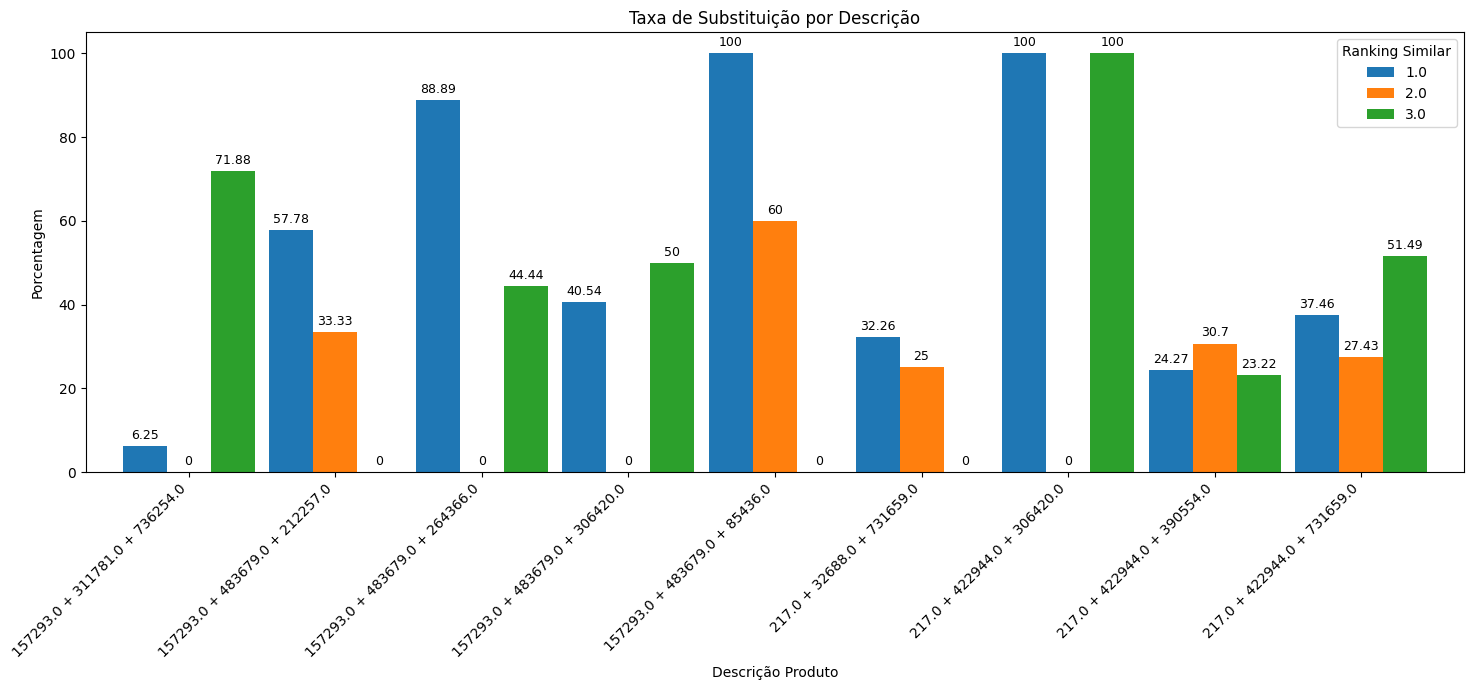

In [22]:
util_graph.create_graph_multi_bar(taxa_substituicao, 'descricao_completa', 'ranking', 'taxa_substituicao', 'Descrição Produto', 'Porcentagem', 
                                  'Taxa de Substituição por Descrição', 'Ranking Similar')

### Diferença do Preço em Relação ao Produto com Ruptura Importa na Preferência do Similar ?

In [23]:
valores_produtos = df_vendas.groupby(['cod_produto', 'key_loja'], as_index=False).agg({'vlr_venda_tabelado_mean':'mean', 'vlr_desconto_mean':'mean'})
valores_produtos.head()

,cod_produto,key_loja,vlr_venda_tabelado_mean,vlr_desconto_mean
0,1428,1,282.623476,41.581585
1,1428,2,295.103066,35.989608
2,1428,3,313.755580,47.799176
3,1428,4,277.357283,38.888882
4,1428,5,325.515359,47.817937


In [24]:
qtd_veandas_por_ranking = vendas_similares.groupby(['cod_produto', 'key_loja', 'ranking'],as_index=False).agg({'qtd_vendas':'sum'})
# qtd_veandas_por_ranking
ordem_preferencia_ranking = (
    qtd_veandas_por_ranking.sort_values(['cod_produto', 'qtd_vendas'],ascending=False)
    .groupby(['cod_produto', 'key_loja'],as_index=False)
    .agg({'ranking':lambda x: ' - '.join(str(int(i)) for i in x)})
    )
ordem_preferencia_ranking

,cod_produto,key_loja,ranking
0,1428,5,3 - 1 - 2
1,1650,5,1 - 3 - 2
2,47851,5,3 - 1
3,47905,5,2
4,48062,5,3 - 1 - 2
5,48145,5,1
6,48562,5,1 - 2
7,48675,5,2 - 1
8,48676,5,3 - 2
9,48680,5,3 - 1


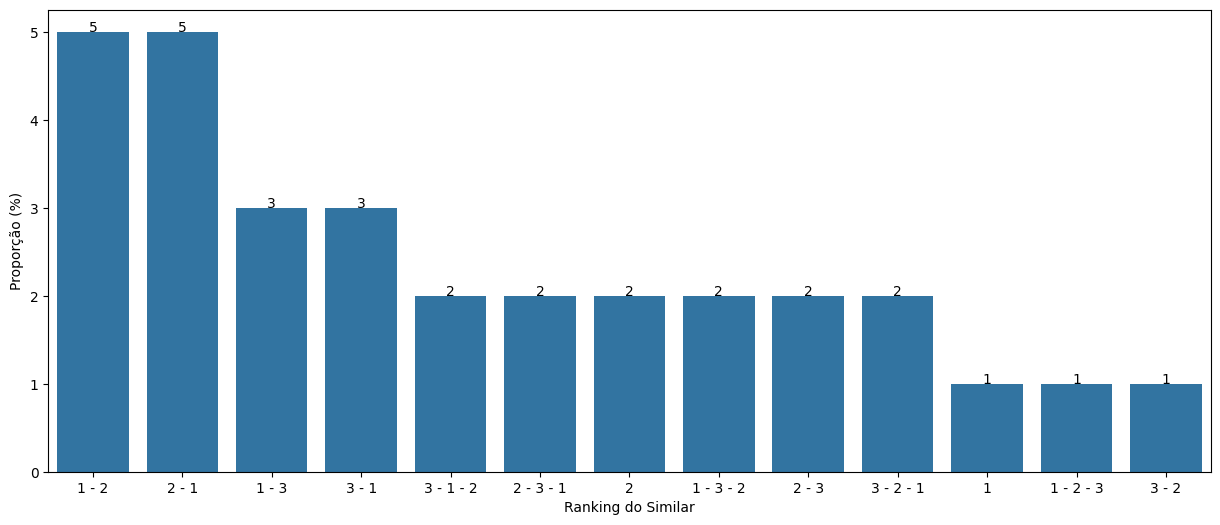

In [25]:
plt.figure(figsize=(15, 6))
df_tmp = ordem_preferencia_ranking['ranking'].value_counts().reset_index()
aux = sns.barplot(x='ranking', y='count', data=df_tmp)

aux.set(xlabel='Ranking do Similar', ylabel='Proporção (%)')
# plt.title(title)

for index, row in df_tmp.iterrows():
    aux.text(row.name, row['count'], row['count'], color='black', ha="center")

plt.show()

In [26]:
ordem_preferencia_ranking['ranking'].value_counts().reset_index()

,ranking,count
0,1 - 2,5
1,2 - 1,5
2,1 - 3,3
3,3 - 1,3
4,3 - 1 - 2,2
5,2 - 3 - 1,2
6,2,2
7,1 - 3 - 2,2
8,2 - 3,2
9,3 - 2 - 1,2


In [27]:
df_tmp

,ranking,count
0,1 - 2,5
1,2 - 1,5
2,1 - 3,3
3,3 - 1,3
4,3 - 1 - 2,2
5,2 - 3 - 1,2
6,2,2
7,1 - 3 - 2,2
8,2 - 3,2
9,3 - 2 - 1,2


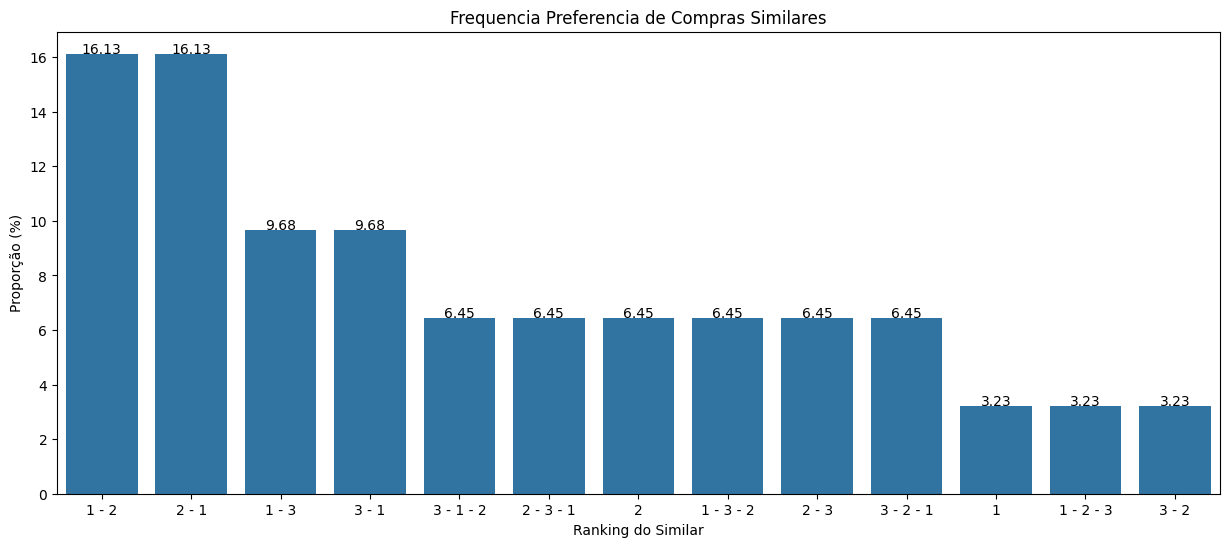

In [28]:
df_tmp = ordem_preferencia_ranking['ranking'].value_counts(normalize=True).reset_index()
df_tmp['proportion'] = np.round(df_tmp['proportion']*100,2)
util_graph.create_graph_bar(df_tmp, 'ranking', 'proportion', 'Ranking do Similar', 'Proporção (%)', 'Frequencia Preferencia de Compras Similares')

<Axes: >

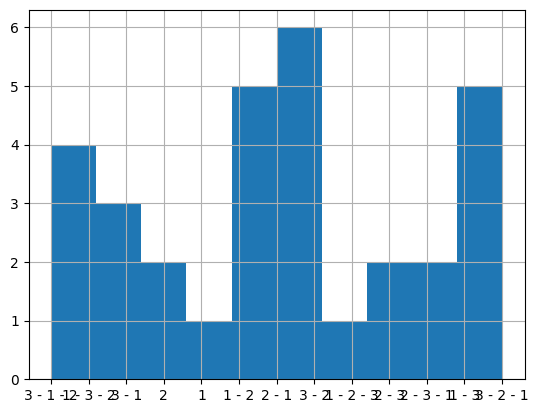

In [29]:
ordem_preferencia_ranking.ranking.hist()

In [30]:
produtos_precos = vendas_similares.merge(
    valores_produtos, 
    left_on=['cod_produto', 'key_loja'], 
    right_on=['cod_produto', 'key_loja'], how='left',
    suffixes=('', '_principal'))

produtos_precos.drop(columns=['dt_venda', 'qtd_vendas', 'vlr_venda_tabelado_mean', 'vlr_desconto_mean'], inplace=True)

vendas_produtos_similar_precos = produtos_precos.merge(
    valores_produtos, 
    left_on=['cod_produto_similar', 'key_loja'], 
    right_on=['cod_produto', 'key_loja'], how='left',
    suffixes=('', '_similar'))

vendas_produtos_similar_precos.drop(columns=['cod_produto_similar'], inplace=True)
vendas_produtos_similar_precos['valor_final_principal'] = vendas_produtos_similar_precos['vlr_venda_tabelado_mean_principal'] - vendas_produtos_similar_precos['vlr_desconto_mean_principal']
vendas_produtos_similar_precos['valor_final_similar'] = vendas_produtos_similar_precos['vlr_venda_tabelado_mean'] - vendas_produtos_similar_precos['vlr_desconto_mean']
vendas_produtos_similar_precos['diff_vlr_final'] = np.round(vendas_produtos_similar_precos['valor_final_similar']-vendas_produtos_similar_precos['valor_final_principal'], 2)

vendas_produtos_similar_precos.loc[vendas_produtos_similar_precos['diff_vlr_final']>0, 'flag_diff_preco'] = 'Mais Caro'
vendas_produtos_similar_precos.loc[vendas_produtos_similar_precos['diff_vlr_final']==0, 'flag_diff_preco'] = 'Mesmo Valor'
vendas_produtos_similar_precos.loc[vendas_produtos_similar_precos['diff_vlr_final']<0, 'flag_diff_preco'] = 'Mais Barato'

vendas_produtos_similar_precos.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,ano_mes,ranking,qt_estoque_similar,similar_disponivel,descricao_completa,venda_similar,vlr_venda_tabelado_mean_principal,vlr_desconto_mean_principal,vlr_venda_tabelado_mean,vlr_desconto_mean,valor_final_principal,valor_final_similar,diff_vlr_final,flag_diff_preco
0,5,1428,2024-11-13,0.0,1,2024-11,1.0,10.0,1,217.0 + 422944.0 + 731659.0,1,325.515359,47.817937,245.562337,46.871643,277.697422,198.690694,-79.01,Mais Barato
1,5,1428,2024-11-13,0.0,1,2024-11,2.0,19.0,1,217.0 + 422944.0 + 731659.0,1,325.515359,47.817937,187.832609,26.909348,277.697422,160.923261,-116.77,Mais Barato
2,5,1428,2024-11-13,0.0,1,2024-11,3.0,1150.0,1,217.0 + 422944.0 + 731659.0,1,325.515359,47.817937,396.263373,26.672790,277.697422,369.590583,91.89,Mais Caro
3,5,1428,2024-11-14,0.0,1,2024-11,1.0,7.0,1,217.0 + 422944.0 + 731659.0,0,325.515359,47.817937,245.562337,46.871643,277.697422,198.690694,-79.01,Mais Barato
4,5,1428,2024-11-14,0.0,1,2024-11,2.0,18.0,1,217.0 + 422944.0 + 731659.0,0,325.515359,47.817937,187.832609,26.909348,277.697422,160.923261,-116.77,Mais Barato


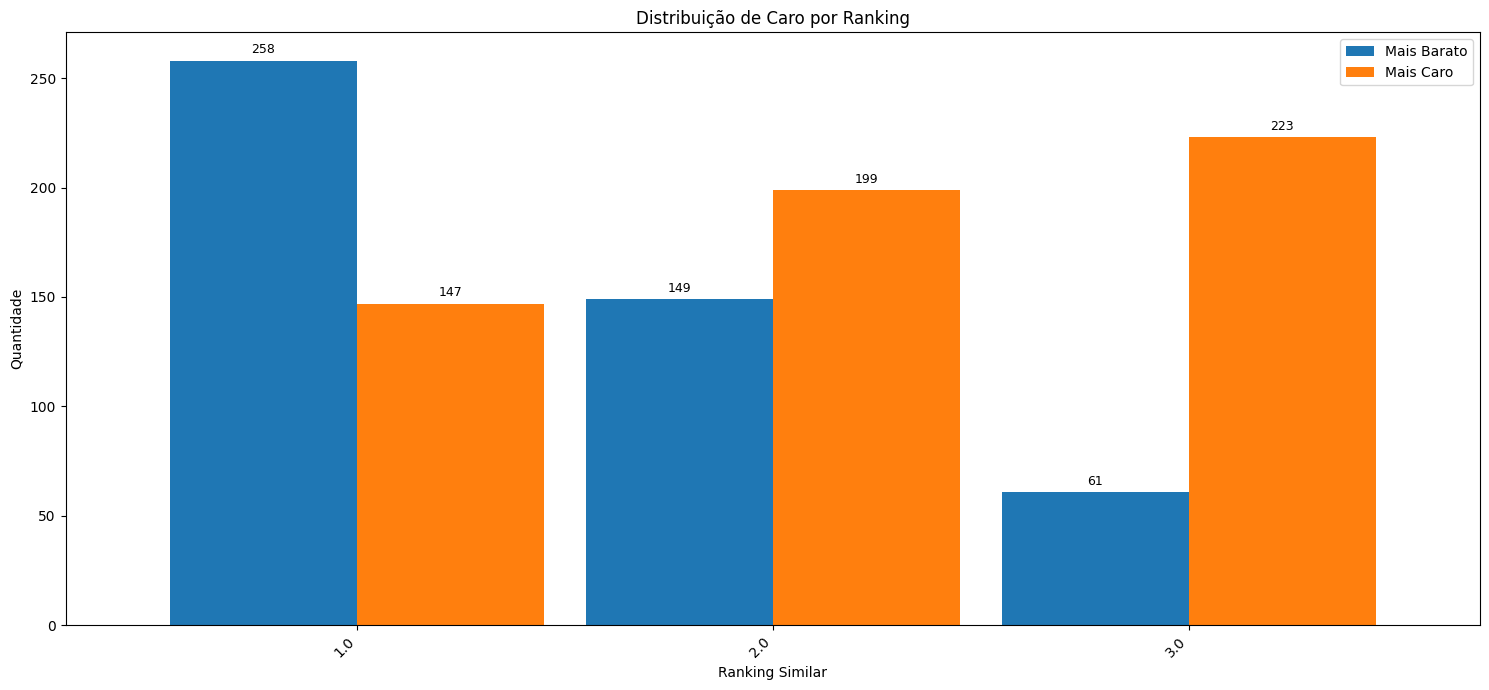

In [31]:
distribuicao_caro_ranking = vendas_produtos_similar_precos[vendas_produtos_similar_precos['venda_similar']==1].groupby('ranking', as_index=False)['flag_diff_preco'].value_counts()
util_graph.create_graph_multi_bar(distribuicao_caro_ranking, 'ranking', 'flag_diff_preco', 'count', 'Ranking Similar', 'Quantidade', 
                                  'Distribuição de Caro por Ranking', '')

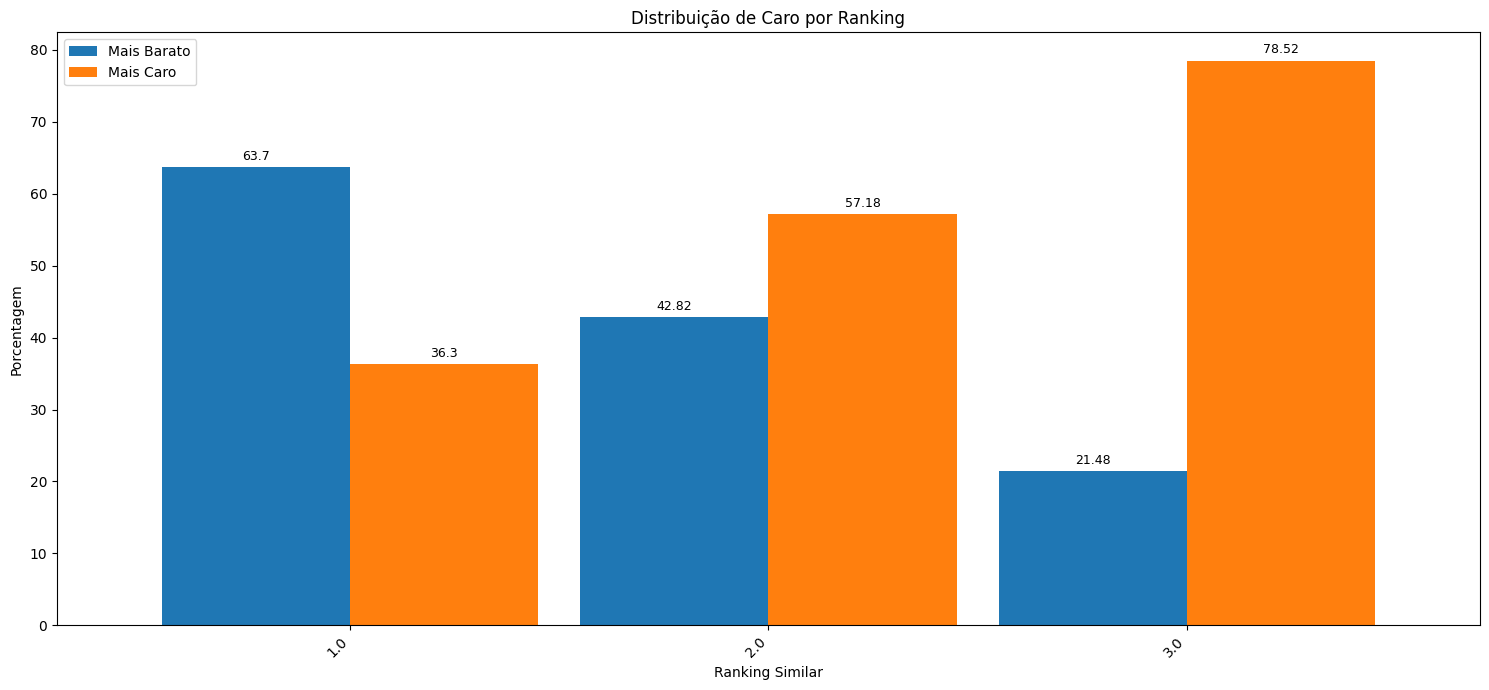

In [32]:
distribuicao_caro_ranking = vendas_produtos_similar_precos[vendas_produtos_similar_precos['venda_similar']==1].groupby('ranking', as_index=False)['flag_diff_preco'].value_counts(normalize=True)
distribuicao_caro_ranking['proportion'] = np.round(distribuicao_caro_ranking['proportion']*100,2)

util_graph.create_graph_multi_bar(distribuicao_caro_ranking, 'ranking', 'flag_diff_preco', 'proportion', 'Ranking Similar', 'Porcentagem', 
                                  'Distribuição de Caro por Ranking', '')

#### As Substituições seguem a ordem da Recomendação?

In [33]:
qtd_veandas_por_ranking = vendas_similares.groupby(['cod_produto', 'key_loja', 'ranking'],as_index=False).agg({'qtd_vendas':'sum'})

ordem_preferencia_ranking = (
    qtd_veandas_por_ranking.sort_values(['cod_produto', 'qtd_vendas'],ascending=False)
    .groupby(['cod_produto', 'key_loja'],as_index=False)
    .agg({'ranking':lambda x: ' - '.join(str(int(i)) for i in x)})
    )

ordem_preferencia_ranking.head()

,cod_produto,key_loja,ranking
0,1428,5,3 - 1 - 2
1,1650,5,1 - 3 - 2
2,47851,5,3 - 1
3,47905,5,2
4,48062,5,3 - 1 - 2


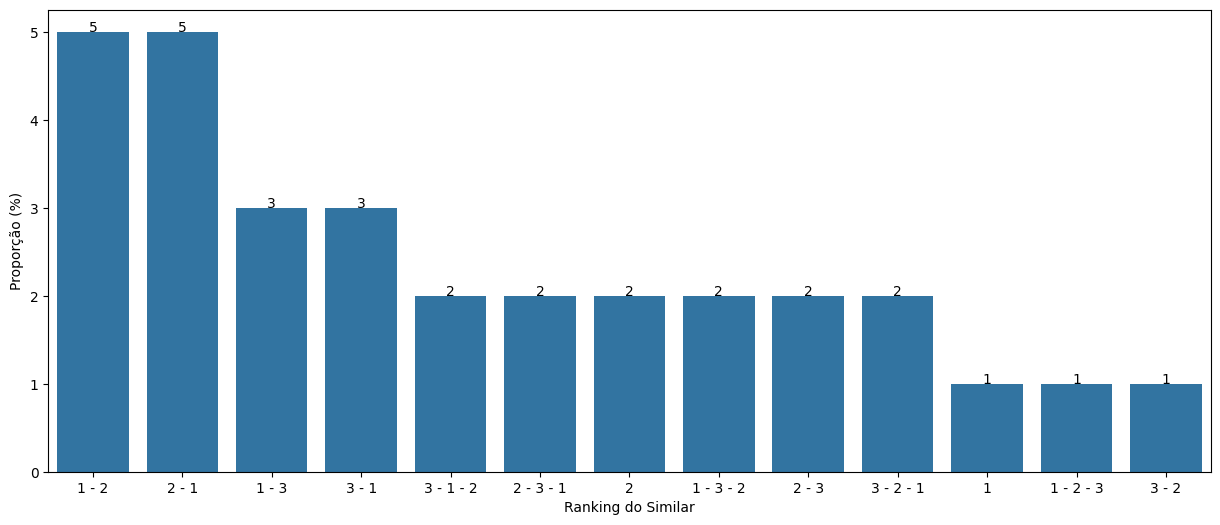

In [34]:
plt.figure(figsize=(15, 6))
df_tmp = ordem_preferencia_ranking['ranking'].value_counts().reset_index()
aux = sns.barplot(x='ranking', y='count', data=df_tmp)

aux.set(xlabel='Ranking do Similar', ylabel='Proporção (%)')
# plt.title(title)

for index, row in df_tmp.iterrows():
    aux.text(row.name, row['count'], row['count'], color='black', ha="center")

plt.show()

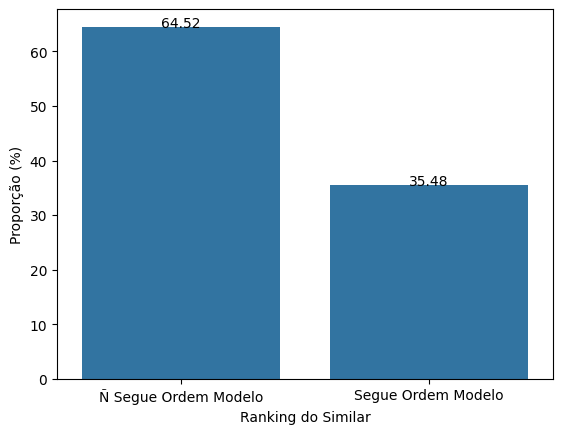

In [35]:
ordem_correta = ['1 - 2 - 3', '1 - 2', '1 - 3', '2 - 3']
ordem_preferencia_ranking['flag_ordem'] = 'Ñ Segue Ordem Modelo'
ordem_preferencia_ranking.loc[ordem_preferencia_ranking['ranking'].isin(ordem_correta), 'flag_ordem'] = 'Segue Ordem Modelo'
df_tmp = ordem_preferencia_ranking['flag_ordem'].value_counts(normalize=True).reset_index()
df_tmp['proportion'] = np.round(df_tmp['proportion']*100, 2)

aux = sns.barplot(x='flag_ordem', y='proportion', data=df_tmp)

aux.set(xlabel='Ranking do Similar', ylabel='Proporção (%)')
# plt.title(title)

for index, row in df_tmp.iterrows():
    aux.text(row.name, row['proportion'], row['proportion'], color='black', ha="center")

plt.show()

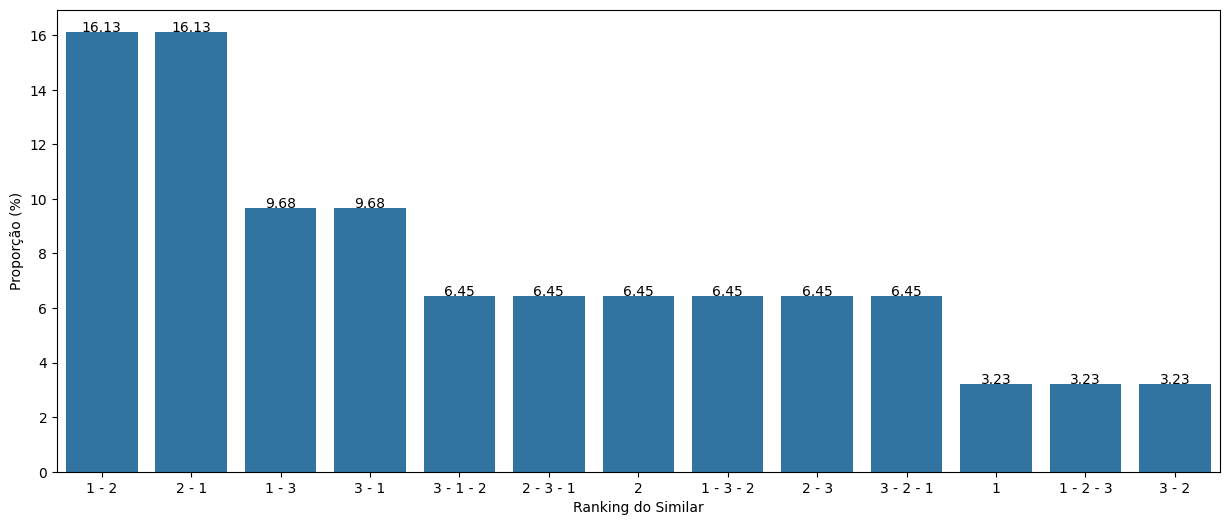

In [36]:
plt.figure(figsize=(15, 6))
df_tmp = ordem_preferencia_ranking['ranking'].value_counts(normalize=True).reset_index()
df_tmp['proportion'] = np.round(df_tmp['proportion']*100, 2)

aux = sns.barplot(x='ranking', y='proportion', data=df_tmp)

aux.set(xlabel='Ranking do Similar', ylabel='Proporção (%)')
# plt.title(title)

for index, row in df_tmp.iterrows():
    aux.text(row.name, row['proportion'], row['proportion'], color='black', ha="center")

plt.show()

# Conclusão

- **Loja 1:**
    - Produtos Similares: Mais da metade dos produtos não possuem produtos similares para serem recomendados 
    - Produtos Disponibilidade Similares: Em geral no momento de ruptura os produtos similares estavam disponiveis em 50% das vezes
        - produtos **sem descrição** e produtos da **categoria 955075** apresentaram as menores taxas de disponibilidades de produtos similares
    - Produtos Preferência na Substituição: Os clientes dessa loja quando se encontravam com uma situação de ruptura e que todos os similares estavam disponiveis optaram na maioria das vezes pelo produto de ranking 2.
        - Pode ser um indicativo que para a loja 1 o modelo de recomendação não esteja tão calibrado
        - Mesmo o ranking 2 sendo mais caro os clientes optaram por compra
        - Em mais de 70% dos produtos a substituição na ruptura não segue a ordem de recomendação do Modelo
- **Loja 2:**
    - Produtos Similares:
    - Produtos Disponibilidade Similares:
    - Produtos Preferência na Substituição:
    - Resumo:
- **Loja 3:**
    - Produtos Similares:
    - Produtos Disponibilidade Similares:
    - Produtos Preferência na Substituição:
    - Resumo:
- **Loja 4:**
    - Produtos Similares:
    - Produtos Disponibilidade Similares:
    - Produtos Preferência na Substituição:
    - Resumo:
- **Loja 5:**
    - Produtos Similares:
    - Produtos Disponibilidade Similares:
    - Produtos Preferência na Substituição:
    - Resumo:
- **Loja 6:**
    - Produtos Similares:
    - Produtos Disponibilidade Similares:
    - Produtos Preferência na Substituição:
    - Resumo:
- **Loja 7:**
    - Produtos Similares:
    - Produtos Disponibilidade Similares:
    - Produtos Preferência na Substituição:
    - Resumo:
- **Loja 8:**
    - Produtos Similares:
    - Produtos Disponibilidade Similares:
    - Produtos Preferência na Substituição:
    - Resumo: